In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
import statistics as stat
import pickle
import sys

/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## Pseudobulk aggregation for decile bins, all cell types

Load all datasets and adjust so that pseudotime ranges from zero to one

In [2]:
endo = sc.read_h5ad('../data/endo.h5ad')
endo = endo[:,endo.var['Selected']==1]
endo.obs['dpt_pseudotime'] = endo.obs['dpt_pseudotime']/max(endo.obs['dpt_pseudotime'])

endo2 = sc.read_h5ad("../data/endo_05.h5ad")
endo2 = endo2[:,endo2.var['Selected']==1]
endo2.obs['dpt_pseudotime'] = endo2.obs['dpt_pseudotime']/max(endo2.obs['dpt_pseudotime'])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [3]:
hep = sc.read_h5ad('../data/hep.h5ad')
hep = hep[:,hep.var['Selected']==1]
hep.obs['dpt_pseudotime'] = hep.obs['dpt_pseudotime']/max(hep.obs['dpt_pseudotime'])

hep2 = sc.read_h5ad('../data/hep_05.h5ad')
hep2 = hep2[:,hep2.var['Selected']==1]
hep2.obs['dpt_pseudotime'] = hep2.obs['dpt_pseudotime']/max(hep2.obs['dpt_pseudotime'])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [4]:
neur = sc.read_h5ad('../data/neur.h5ad')
neur = neur[:,neur.var['Selected']==1]
neur.obs['dpt_pseudotime'] = neur.obs['dpt_pseudotime']/max(neur.obs['dpt_pseudotime'])

neur2 = sc.read_h5ad('../data/neur_05.h5ad')
neur2 = neur2[:,neur2.var['Selected']==1]
neur2.obs['dpt_pseudotime'] = neur2.obs['dpt_pseudotime']/max(neur2.obs['dpt_pseudotime'])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Look at the distribution of pseudotime across cells within each lineage

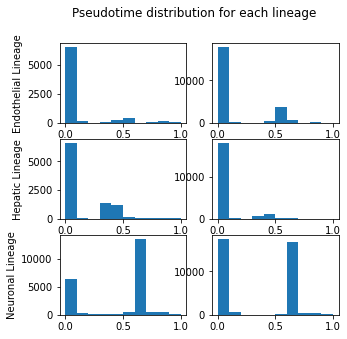

In [5]:
fig, axs = pl.subplots(3,2, figsize=(5,5))
fig.suptitle('Pseudotime distribution for each lineage')
axs[0,0].hist(endo.obs['dpt_pseudotime'], bins=10)
axs[0,1].hist(endo2.obs['dpt_pseudotime'], bins=10)
axs[0,0].set(ylabel="Endothelial Lineage")
axs[1,0].hist(hep.obs['dpt_pseudotime'], bins=10)
axs[1,1].hist(hep2.obs['dpt_pseudotime'], bins=10)
axs[1,0].set(ylabel="Hepatic Lineage")
axs[2,0].hist(neur.obs['dpt_pseudotime'], bins=10)
axs[2,1].hist(neur2.obs['dpt_pseudotime'], bins=10)
axs[2,0].set(ylabel="Neuronal Lineage")
pl.show()

### Endothelial Lineage

Create decile bins, aggregating pseudobulk as in [Ding et al 2019](https://www.biorxiv.org/content/10.1101/632216v1.full.pdf+html)

Adjust for library size and log normalize

In [6]:
_, nG = endo.X.shape
n_bins = 5
nC = n_bins
counts = endo.X
t = np.zeros(nC)
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/n_bins
for c in range(nC):
    if c == nC:
        time_subset = (c*bin_w <= endo.obs['dpt_pseudotime']) & (endo.obs['dpt_pseudotime'] <= (c+1)*bin_w)
    else:
        time_subset = (c*bin_w <= endo.obs['dpt_pseudotime']) & (endo.obs['dpt_pseudotime'] < (c+1)*bin_w)
    endo_c = endo[time_subset]
    exp_c = csr_matrix.sum(endo_c.X, 0)/csr_matrix.sum(endo_c.X)
    exp_c = np.log(10**4 * exp_c + 1)
    numcells[c] = endo_c.shape[0]
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(endo_c.obs['dpt_pseudotime'])

If the distribution of expression values across bins were dramatically different, we may need to use quantile normalization (which does not appear to be the norm in pseudobulk) - this doesn't seem to be the case in our data

IndexError: index 6 is out of bounds for axis 0 with size 5

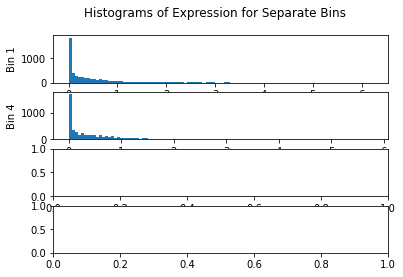

In [5]:
fig, (ax1, ax2, ax3, ax4) = pl.subplots(4,1)
fig.suptitle('Histograms of Expression for Separate Bins')
ax1.hist(Y[0,:], bins=100)
ax1.set(ylabel="Bin 1")
ax2.hist(Y[3,:], bins=100)
ax2.set(ylabel="Bin 4")
ax3.hist(Y[6,:], bins=100)
ax3.set(ylabel="Bin 7")
ax4.hist(Y[9,:], bins=100)
ax4.set(ylabel="Bin 10", xlabel="Lognorm Expression")
pl.show()

Center and scale the data

In [6]:
for g in range(Y.shape[1]):
    if stat.stdev(Y[:,g])==0:
        Y[:,g] = np.zeros(nC)
    else:
        Y[:,g] = (Y[:,g]-np.mean(Y[:,g]))/stat.stdev(Y[:,g])
Yflat = Y.flatten()

Take a look at expression of some key marker genes for this lineage

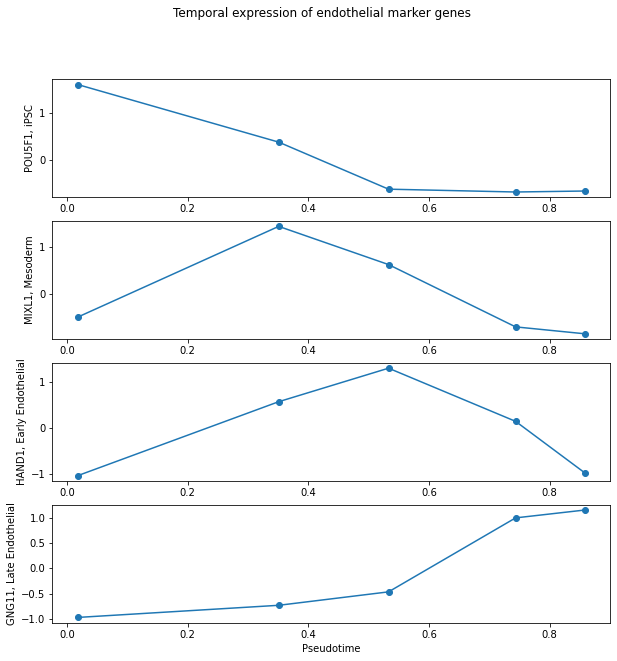

In [7]:
genedict = {endo.var.index[i]:i for i in range(len(endo.var.index))}
fig, (ax1, ax2, ax3, ax4) = pl.subplots(4,1, figsize=(10,10))
fig.suptitle('Temporal expression of endothelial marker genes')
ax1.plot(t, Y[:,genedict["POU5F1"]], "-o")
ax1.set(ylabel="POU5F1, iPSC")
ax2.plot(t, Y[:,genedict["MIXL1"]], "-o")
ax2.set(ylabel="MIXL1, Mesoderm")
ax3.plot(t, Y[:,genedict["HAND1"]], "-o")
ax3.set(ylabel="HAND1, Early Endothelial")
ax4.plot(t, Y[:,genedict["GNG11"]], "-o")
ax4.set(ylabel="GNG11, Late Endothelial")
ax4.set(xlabel="Pseudotime")
pl.show()

Compose metadata for splitGPM to use

In [8]:
X = np.zeros([nC*nG,3])
for c in range(nC):
    X[c*nG:((c+1)*nG),0] = t[c]
    X[c*nG:((c+1)*nG),1] = c
    X[c*nG:((c+1)*nG),2] = list(range(nG))

Save files for splitGPM

In [9]:
np.savetxt( "../data/endo.comb.X.txt", X)
np.savetxt("../data/endo.comb.Y.txt", Yflat)
with open("../data/genedict.endo.comb.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()

#### Subdivide by individual or batch

Subset to only the main three individuals, and look at a breakdown of how many cells belong to each

In [10]:
endo = endo[endo.obs['individual'].isin(['SNG-NA18858', 'SNG-NA19160', 'SNG-NA18511']),:]
print(endo.obs['individual'].value_counts())
print("\n")
print(endo.obs['Batch'].value_counts())

SNG-NA18858    5313
SNG-NA19160    1256
SNG-NA18511    1032
Name: individual, dtype: int64


Batch3    3263
Batch1    2705
Batch2    1633
Name: Batch, dtype: int64


Subset both by individual and by batch

In [11]:
indivs = np.unique(endo.obs['individual'])
batches = np.unique(endo.obs['Batch'])
n_inds = len(indivs)
n_batches = len(batches)
n_bins = 5
_, nG = endo.X.shape
nC_ind = n_inds * n_bins
nC_batch = n_batches * n_bins
counts = endo.X
t_ind = np.zeros(nC_ind)
t_batch = np.zeros(nC_batch)
ind = []
batch = []
numcells_ind = np.zeros(nC_ind)
numcells_batch = np.zeros(nC_batch)
Y_ind = np.zeros([nC_ind, nG])
Y_batch = np.zeros([nC_batch, nG])
bin_w = 1/n_bins
for t_bin in range(n_bins):
    time_subset = (t_bin*bin_w <= endo.obs['dpt_pseudotime']) & (endo.obs['dpt_pseudotime'] < (t_bin+1)*bin_w)
    for i in range(n_inds):
        c = (n_inds * t_bin) + i
        ind_subset = (endo.obs['individual'] == indivs[i])
        endo_c = endo[time_subset & ind_subset]
        exp_c = csr_matrix.sum(endo_c.X, 0)/csr_matrix.sum(endo_c.X)
        exp_c = np.log(10**4 * exp_c + 1)
        numcells_ind[c] = endo_c.shape[0]
        Y_ind[int(c),:] = exp_c
        t_ind[int(c)] = np.median(endo_c.obs['dpt_pseudotime'])
        ind.append(indivs[i])
    for b in range(n_batches):
        c = (n_batches * t_bin) + b
        batch_subset = (endo.obs['Batch'] == batches[b])
        endo_c = endo[time_subset & batch_subset]
        exp_c = csr_matrix.sum(endo_c.X, 0)/csr_matrix.sum(endo_c.X)
        exp_c = np.log(10**4 * exp_c + 1)
        numcells_batch[c] = endo_c.shape[0]
        Y_batch[int(c),:] = exp_c
        t_batch[int(c)] = np.median(endo_c.obs['dpt_pseudotime'])
        batch.append(batches[b])
ind = np.array(ind)
batch = np.array(batch)

In [12]:
for g in range(Y_ind.shape[1]):
    if stat.stdev(Y_ind[:,g])==0:
        Y_ind[:,g] = np.zeros(nC_ind)
    else:
        Y_ind[:,g] = (Y_ind[:,g]-np.mean(Y_ind[:,g]))/stat.stdev(Y_ind[:,g])
    
    if stat.stdev(Y_batch[:,g])==0:
        Y_batch[:,g] = np.zeros(nC_batch)
    else:
        Y_batch[:,g] = (Y_batch[:,g]-np.mean(Y_batch[:,g]))/stat.stdev(Y_batch[:,g])
Yflat_ind = Y_ind.flatten()
Yflat_batch = Y_batch.flatten()

Look at trends in expression of marker genes and how they vary across individuals and batches

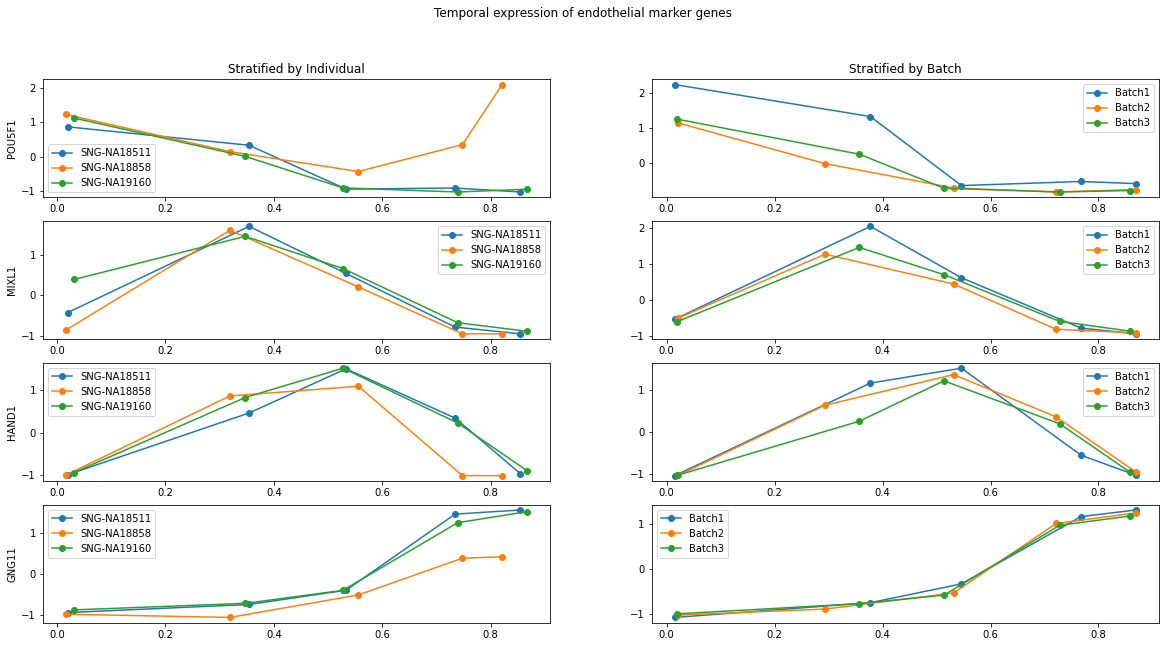

In [13]:
genedict = {endo.var.index[i]:i for i in range(len(endo.var.index))}
fig, axs = pl.subplots(nrows=4, ncols=2, figsize=(20,10))
fig.suptitle('Temporal expression of endothelial marker genes')
markers = ['POU5F1', 'MIXL1', 'HAND1', 'GNG11']
for r in range(len(markers)):
    for i in indivs:
        axs[r,0].plot(t_ind[np.where(ind==i)], np.transpose(Y_ind[np.where(ind==i),genedict[markers[r]]]), "-o", label=i)
    axs[r,0].set(ylabel=markers[r])
    axs[r,0].legend()
    for b in batches:
        axs[r,1].plot(t_batch[np.where(batch==b)], np.transpose(Y_batch[np.where(batch==b),genedict[markers[r]]]), "-o", label=b)
    axs[r,1].legend()
axs[0,0].set_title("Stratified by Individual")
axs[0,1].set_title("Stratified by Batch")
pl.show()

Put together metadata for SplitGPM

In [23]:
X_ind = np.zeros([nC_ind*nG,3])
X_batch = np.zeros([nC_batch*nG,3])
for ti in range(n_bins):
    for i in range(n_inds):
        c = (n_inds * ti) + i
        X_ind[c*nG:((c+1)*nG),0] = t_ind[c]
        X_ind[c*nG:((c+1)*nG),1] = i
        X_ind[c*nG:((c+1)*nG),2] = range(nG)
    for b in range(n_batches):
        c = (n_batches * ti) + b
        X_batch[c*nG:((c+1)*nG),0] = t_batch[c]
        X_batch[c*nG:((c+1)*nG),1] = b
        X_batch[c*nG:((c+1)*nG),2] = list(range(nG))

Save for splitGPM

In [25]:
np.savetxt( "../data/endo.ind.X.txt", X_ind)
np.savetxt("../data/endo.ind.Y.txt", Yflat_ind)
np.savetxt( "../data/endo.batch.X.txt", X_batch)
np.savetxt("../data/endo.batch.Y.txt", Yflat_batch)

#### Subdivide by both individual and batch

In [5]:
endo = endo[endo.obs['individual'].isin(['SNG-NA18858', 'SNG-NA19160', 'SNG-NA18511']),:]
print(endo.obs['individual'].value_counts())
print("\n")
print(endo.obs['Batch'].value_counts())

SNG-NA18858    5313
SNG-NA19160    1256
SNG-NA18511    1032
Name: individual, dtype: int64


Batch3    3263
Batch1    2705
Batch2    1633
Name: Batch, dtype: int64


In [9]:
indivs = np.unique(endo.obs['individual'])
batches = np.unique(endo.obs['Batch'])
n_ind = len(indivs)
n_batch = len(batches)
n_bins = 5
nC = n_ind * n_batch * n_bins
_, nG = endo.X.shape
counts = endo.X
t = np.zeros(nC)
ind = []
batch = []
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/n_bins
for t_bin in range(n_bins):
    if t_bin < n_bins-1 :
        time_subset = (t_bin*bin_w <= endo.obs['dpt_pseudotime']) & (endo.obs['dpt_pseudotime'] < (t_bin+1)*bin_w)
    else:
        time_subset = (t_bin*bin_w <= endo.obs['dpt_pseudotime']) & (endo.obs['dpt_pseudotime'] <= (t_bin+1)*bin_w)
    for i in range(n_ind):
        ind_subset = (endo.obs['individual'] == indivs[i])
        for b in range(n_batch):
            batch_subset = (endo.obs['Batch'] == batches[b])
            endo_c = endo[time_subset & ind_subset & batch_subset]
            exp_c = csr_matrix.sum(endo_c.X, 0)/csr_matrix.sum(endo_c.X)
            exp_c = np.log(10**4 * exp_c + 1)
            
            c = t_bin*n_ind*n_batch + i*n_batch + b
            numcells[c] = endo_c.shape[0]
            
            Y[int(c),:] = exp_c
            t[int(c)] = np.median(endo_c.obs['dpt_pseudotime'])
            ind.append(indivs[i])
            batch.append(batches[b])
ind = np.array(ind)
batch = np.array(batch)

/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/work-zfs/abattle4/josh/ebpilot/myenv/lib/pyth

In [11]:
sum(numcells==0)

5

### Hepatic Lineage

In [ ]:
_, nG = hep.X.shape
nC = 10
counts = hep.X
t = np.zeros(nC)
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/nC
for c in range(nC):
    hep_c = hep[(c*bin_w <= hep.obs['dpt_pseudotime']) & (hep.obs['dpt_pseudotime'] < (c+1)*bin_w)]
    exp_c = csr_matrix.sum(hep_c.X, 0)/csr_matrix.sum(hep_c.X)
    exp_c = np.log(10**4 * exp_c + 1)
    numcells[c] = hep_c.shape[0]
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(hep_c.obs['dpt_pseudotime'])

In [ ]:
for g in range(Y.shape[1]):
    if stat.stdev(Y[:,g])==0:
        Y[:,g] = np.zeros(10)
    else:
        Y[:,g] = (Y[:,g]-np.mean(Y[:,g]))/stat.stdev(Y[:,g])
Yflat = Y.flatten()

In [ ]:
genedict = {hep.var.index[i]:i for i in range(len(hep.var.index))}
fig, (ax1, ax2, ax3) = pl.subplots(3,1, figsize=(10,10))
fig.suptitle('Temporal expression of hepatic marker genes')
ax1.plot(t, Y[:,genedict["POU5F1"]], "-o")
ax1.set(ylabel="POU5F1, iPSC")
ax2.plot(t, Y[:,genedict["KRT18"]], "-o")
ax2.set(ylabel="KRT18, Early Hepatocyte")
ax3.plot(t, Y[:,genedict["ALB"]], "-o")
ax3.set(ylabel="ALB, Late Hepatocyte", xlabel="Pseudotime")
pl.show()

In [ ]:
X = np.zeros([nC*nG,3])
for c in range(nC):
    X[c*nG:((c+1)*nG),0] = t[c]
    X[c*nG:((c+1)*nG),1] = c
    X[c*nG:((c+1)*nG),2] = list(range(nG))

In [ ]:
np.savetxt( "../data/hep.X.txt", X)
np.savetxt("../data/hep.Y.txt", Yflat)
with open("../data/genedict.hep.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()

#### Subdivide by individual and by batch

In [3]:
hep = hep[hep.obs['individual'].isin(['SNG-NA18858', 'SNG-NA19160', 'SNG-NA18511']),:]
print(hep.obs['individual'].value_counts())
print("\n")
print(hep.obs['Batch'].value_counts())

SNG-NA18858    5474
SNG-NA19160    2019
SNG-NA18511    1519
Name: individual, dtype: int64


Batch3    4071
Batch1    3022
Batch2    1919
Name: Batch, dtype: int64


In [18]:
indivs = np.unique(hep.obs['individual'])
batches = np.unique(hep.obs['Batch'])
n_inds = len(indivs)
n_batches = len(batches)
n_bins = 4
_, nG = hep.X.shape
nC_ind = n_inds * n_bins
nC_batch = n_batches * n_bins
counts = hep.X
t_ind = np.zeros(nC_ind)
t_batch = np.zeros(nC_batch)
ind = []
batch = []
numcells_ind = np.zeros(nC_ind)
numcells_batch = np.zeros(nC_batch)
Y_ind = np.zeros([nC_ind, nG])
Y_batch = np.zeros([nC_batch, nG])
bin_w = 1/n_bins
for t_bin in range(n_bins):
    time_subset = (t_bin*bin_w <= hep.obs['dpt_pseudotime']) & (hep.obs['dpt_pseudotime'] < (t_bin+1)*bin_w)
    for i in range(n_inds):
        c = (n_inds * t_bin) + i
        ind_subset = (hep.obs['individual'] == indivs[i])
        hep_c = hep[time_subset & ind_subset]
        exp_c = csr_matrix.sum(hep_c.X, 0)/csr_matrix.sum(hep_c.X)
        exp_c = np.log(10**4 * exp_c + 1)
        numcells_ind[c] = hep_c.shape[0]
        Y_ind[int(c),:] = exp_c
        t_ind[int(c)] = np.median(hep_c.obs['dpt_pseudotime'])
        ind.append(indivs[i])
    for b in range(n_batches):
        c = (n_batches * t_bin) + b
        batch_subset = (hep.obs['Batch'] == batches[b])
        hep_c = hep[time_subset & batch_subset]
        exp_c = csr_matrix.sum(hep_c.X, 0)/csr_matrix.sum(hep_c.X)
        exp_c = np.log(10**4 * exp_c + 1)
        numcells_batch[c] = hep_c.shape[0]
        Y_batch[int(c),:] = exp_c
        t_batch[int(c)] = np.median(hep_c.obs['dpt_pseudotime'])
        batch.append(batches[b])
ind = np.array(ind)
batch = np.array(batch)

/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


PROBLEM: there seems to be an individual that doesn't have cells even close to one of the time bins (empty for both 4 and 5 bins) - how can this be adapted to handle missing data?

In [14]:
for g in range(Y_ind.shape[1]):
    if stat.stdev(Y_ind[:,g])==0:
        Y_ind[:,g] = np.zeros(nC_ind)
    else:
        Y_ind[:,g] = (Y_ind[:,g]-np.mean(Y_ind[:,g]))/stat.stdev(Y_ind[:,g])
    
    if stat.stdev(Y_batch[:,g])==0:
        Y_batch[:,g] = np.zeros(nC_batch)
    else:
        Y_batch[:,g] = (Y_batch[:,g]-np.mean(Y_batch[:,g]))/stat.stdev(Y_batch[:,g])
Yflat_ind = Y_ind.flatten()
Yflat_batch = Y_batch.flatten()

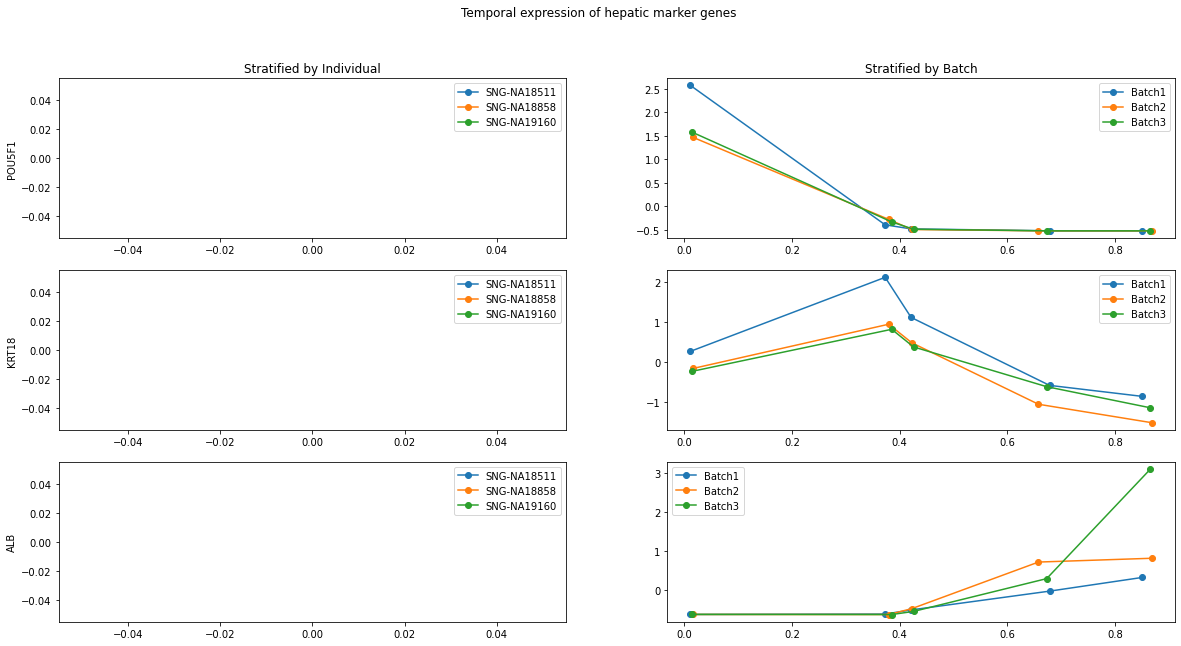

In [10]:
genedict = {hep.var.index[i]:i for i in range(len(hep.var.index))}
fig, axs = pl.subplots(nrows=3, ncols=2, figsize=(20,10))
fig.suptitle('Temporal expression of hepatic marker genes')
markers = ['POU5F1', 'KRT18', 'ALB']
for r in range(len(markers)):
    for i in indivs:
        axs[r,0].plot(t_ind[np.where(ind==i)], np.transpose(Y_ind[np.where(ind==i),genedict[markers[r]]]), "-o", label=i)
    axs[r,0].set(ylabel=markers[r])
    axs[r,0].legend()
    for b in batches:
        axs[r,1].plot(t_batch[np.where(batch==b)], np.transpose(Y_batch[np.where(batch==b),genedict[markers[r]]]), "-o", label=b)
    axs[r,1].legend()
axs[0,0].set_title("Stratified by Individual")
axs[0,1].set_title("Stratified by Batch")
pl.show()

### Neuronal Lineage

In [9]:
_, nG = neur.X.shape
nC = 10
counts = neur.X
t = np.zeros(nC)
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/nC
for c in range(nC):
    neur_c = neur[(c*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] < (c+1)*bin_w)]
    exp_c = csr_matrix.sum(neur_c.X, 0)/csr_matrix.sum(neur_c.X)
    exp_c = np.log(10**4 * exp_c + 1)
    numcells[c] = neur_c.shape[0]
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])

In [10]:
for g in range(Y.shape[1]):
    if stat.stdev(Y[:,g])==0:
        Y[:,g] = np.zeros(10)
    else:
        Y[:,g] = (Y[:,g]-np.mean(Y[:,g]))/stat.stdev(Y[:,g])
Yflat = Y.flatten()

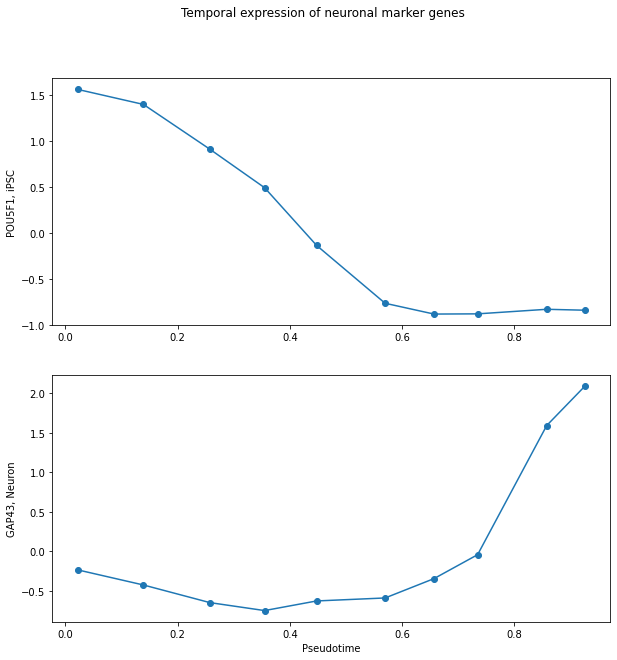

In [11]:
genedict = {neur.var.index[i]:i for i in range(len(neur.var.index))}
fig, (ax1, ax2) = pl.subplots(2,1, figsize=(10,10))
fig.suptitle('Temporal expression of neuronal marker genes')
ax1.plot(t, Y[:,genedict["POU5F1"]], "-o")
ax1.set(ylabel="POU5F1, iPSC")
ax2.plot(t, Y[:,genedict["GAP43"]], "-o")
ax2.set(ylabel="GAP43, Neuron", xlabel="Pseudotime")
pl.show()

In [ ]:
X = np.zeros([nC*nG,3])
for c in range(nC):
    X[c*nG:((c+1)*nG),0] = t[c]
    X[c*nG:((c+1)*nG),1] = c
    X[c*nG:((c+1)*nG),2] = list(range(nG))

In [ ]:
np.savetxt( "../data/neur.X.txt", X)
np.savetxt("../data/neur.Y.txt", Yflat)
with open("../data/genedict.neur.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()

#### Subset by individual and by batch

In [7]:
neur = neur[neur.obs['individual'].isin(['SNG-NA18858', 'SNG-NA19160', 'SNG-NA18511']),:]
print(neur.obs['individual'].value_counts())
print("\n")
print(neur.obs['Batch'].value_counts())

SNG-NA18511    7494
SNG-NA18858    6222
SNG-NA19160    4747
Name: individual, dtype: int64


Batch1    7676
Batch3    6321
Batch2    4466
Name: Batch, dtype: int64


In [8]:
indivs = np.unique(neur.obs['individual'])
batches = np.unique(neur.obs['Batch'])
n_inds = len(indivs)
n_batches = len(batches)
n_bins = 5
_, nG = neur.X.shape
nC_ind = n_inds * n_bins
nC_batch = n_batches * n_bins
counts = neur.X
t_ind = np.zeros(nC_ind)
t_batch = np.zeros(nC_batch)
ind = []
batch = []
numcells_ind = np.zeros(nC_ind)
numcells_batch = np.zeros(nC_batch)
Y_ind = np.zeros([nC_ind, nG])
Y_batch = np.zeros([nC_batch, nG])
bin_w = 1/n_bins
for t_bin in range(n_bins):
    time_subset = (t_bin*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] < (t_bin+1)*bin_w)
    for i in range(n_inds):
        c = (n_inds * t_bin) + i
        ind_subset = (neur.obs['individual'] == indivs[i])
        neur_c = neur[time_subset & ind_subset]
        exp_c = csr_matrix.sum(neur_c.X, 0)/csr_matrix.sum(neur_c.X)
        exp_c = np.log(10**4 * exp_c + 1)
        numcells_ind[c] = neur_c.shape[0]
        Y_ind[int(c),:] = exp_c
        t_ind[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])
        ind.append(indivs[i])
    for b in range(n_batches):
        c = (n_batches * t_bin) + b
        batch_subset = (neur.obs['Batch'] == batches[b])
        neur_c = neur[time_subset & batch_subset]
        exp_c = csr_matrix.sum(neur_c.X, 0)/csr_matrix.sum(neur_c.X)
        exp_c = np.log(10**4 * exp_c + 1)
        numcells_batch[c] = neur_c.shape[0]
        Y_batch[int(c),:] = exp_c
        t_batch[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])
        batch.append(batches[b])
ind = np.array(ind)
batch = np.array(batch)

In [9]:
for g in range(Y_ind.shape[1]):
    if stat.stdev(Y_ind[:,g])==0:
        Y_ind[:,g] = np.zeros(nC_ind)
    else:
        Y_ind[:,g] = (Y_ind[:,g]-np.mean(Y_ind[:,g]))/stat.stdev(Y_ind[:,g])
    
    if stat.stdev(Y_batch[:,g])==0:
        Y_batch[:,g] = np.zeros(nC_batch)
    else:
        Y_batch[:,g] = (Y_batch[:,g]-np.mean(Y_batch[:,g]))/stat.stdev(Y_batch[:,g])
Yflat_ind = Y_ind.flatten()
Yflat_batch = Y_batch.flatten()

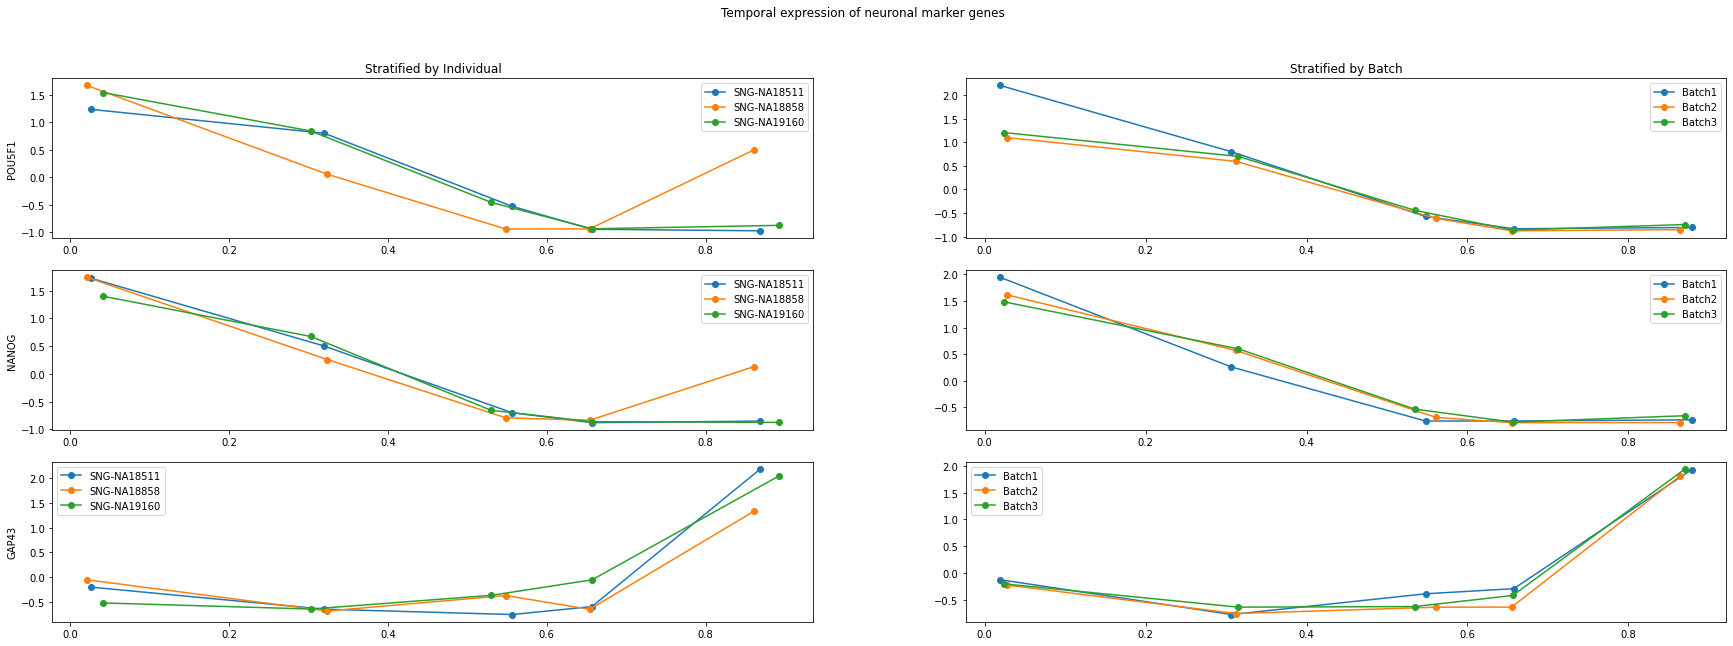

In [10]:
genedict = {neur.var.index[i]:i for i in range(len(neur.var.index))}
fig, axs = pl.subplots(nrows=3, ncols=2, figsize=(30,10))
fig.suptitle('Temporal expression of neuronal marker genes')
markers = ['POU5F1', 'NANOG', 'GAP43']
for r in range(len(markers)):
    for i in indivs:
        axs[r,0].plot(t_ind[np.where(ind==i)], np.transpose(Y_ind[np.where(ind==i),genedict[markers[r]]]), "-o", label=i)
    axs[r,0].set(ylabel=markers[r])
    axs[r,0].legend()
    for b in batches:
        axs[r,1].plot(t_batch[np.where(batch==b)], np.transpose(Y_batch[np.where(batch==b),genedict[markers[r]]]), "-o", label=b)
    axs[r,1].legend()
axs[0,0].set_title("Stratified by Individual")
axs[0,1].set_title("Stratified by Batch")
pl.show()

#### Subset by both individual and batch

In [11]:
indivs = np.unique(neur.obs['individual'])
batches = np.unique(neur.obs['Batch'])
n_ind = len(indivs)
n_batch = len(batches)
n_bins = 5
nC = n_ind * n_batch * n_bins
_, nG = neur.X.shape
counts = neur.X
t = np.zeros(nC)
ind = []
batch = []
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/n_bins
for t_bin in range(n_bins):
    if t_bin < n_bins-1 :
        time_subset = (t_bin*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] < (t_bin+1)*bin_w)
    else:
        time_subset = (t_bin*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] <= (t_bin+1)*bin_w)
    for i in range(n_ind):
        ind_subset = (neur.obs['individual'] == indivs[i])
        for b in range(n_batch):
            batch_subset = (neur.obs['Batch'] == batches[b])
            neur_c = neur[time_subset & ind_subset & batch_subset]
            exp_c = csr_matrix.sum(neur_c.X, 0)/csr_matrix.sum(neur_c.X)
            exp_c = np.log(10**4 * exp_c + 1)
            
            c = t_bin*n_ind*n_batch + i*n_batch + b
            numcells[c] = neur_c.shape[0]
            
            Y[int(c),:] = exp_c
            t[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])
            ind.append(indivs[i])
            batch.append(batches[b])
ind = np.array(ind)
batch = np.array(batch)

Some small batches here but all non-zero

In [12]:
for g in range(Y.shape[1]):
    if stat.stdev(Y[:,g])==0:
        Y[:,g] = np.zeros(nC)
    else:
        Y[:,g] = (Y[:,g]-np.mean(Y[:,g]))/stat.stdev(Y[:,g])
Yflat= Y.flatten()

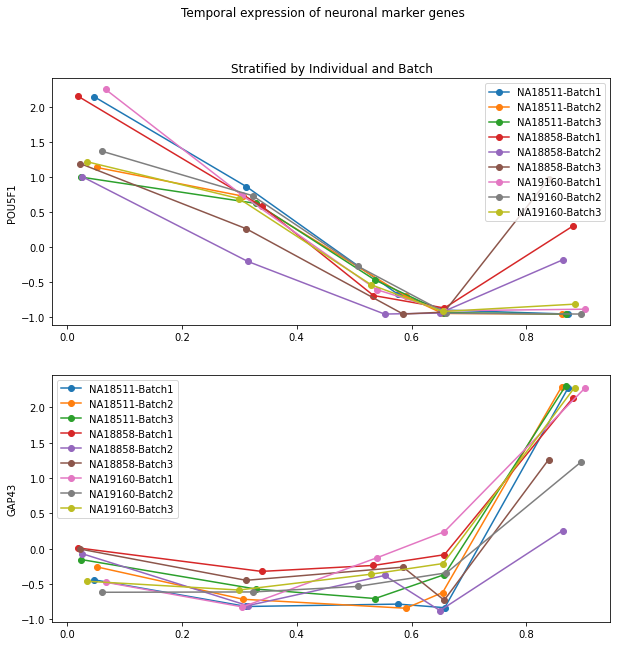

In [19]:
genedict = {neur.var.index[i]:i for i in range(len(neur.var.index))}
fig, axs = pl.subplots(nrows=2, ncols=1, figsize=(10,10))
fig.suptitle('Temporal expression of neuronal marker genes')
markers = ['POU5F1', 'GAP43']
for r in range(len(markers)):
    for i in indivs:
        for b in batches:
            lab = i[4:]+"-"+b
            axs[r].plot(t[np.where((ind==i) & (batch==b))], np.transpose(Y[np.where((ind==i) & (batch==b)),genedict[markers[r]]]), "-o", label=lab)
    axs[r].set(ylabel=markers[r])
    axs[r].legend()
axs[0].set_title("Stratified by Individual and Batch")
pl.show()

In [20]:
X = np.zeros([nC*nG,3])
for ti in range(n_bins):
    for i in range(n_ind):
        for b in range(n_batch):
            c = ti * n_ind * n_batch + i * n_batch + b
            X[c*nG:((c+1)*nG),0] = t[c]
            X[c*nG:((c+1)*nG),1] = i * n_batch + b
            X[c*nG:((c+1)*nG),2] = list(range(nG))

In [14]:
np.savetxt( "../data/neur.X.batchind.txt", X)
np.savetxt("../data/neur.Y.batchind.txt", Yflat)
with open("../data/genedict.neur.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()

Are terminal and pluripotency marker genes actually being coexpressed in later pseudotime bins?

In [22]:
time_subset = (t_bin*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] <= (t_bin+1)*bin_w)
late_cells = neur[time_subset]

Normalize data

In [27]:
sc.pp.normalize_total(late_cells, target_sum=1e6)
sc.pp.log1p(late_cells)

/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


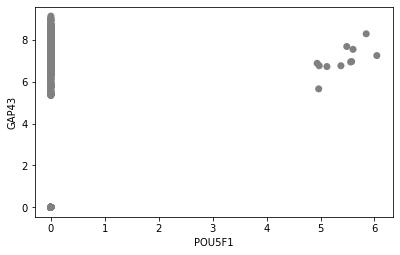

In [28]:
sc.pl.scatter(late_cells, 'POU5F1', 'GAP43')

#### Subset reclustered data by batch and ind

In [37]:
indivs = np.unique(neur2.obs['individual'])
batches = np.unique(neur2.obs['Batch'])
n_ind = len(indivs)
n_batch = len(batches)
n_bins = 4
nC = n_ind * n_batch * n_bins
_, nG = neur2.X.shape
counts = neur2.X
t = np.zeros(nC)
ind = []
batch = []
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/n_bins
for t_bin in range(n_bins):
    if t_bin < n_bins-1 :
        time_subset = (t_bin*bin_w <= neur2.obs['dpt_pseudotime']) & (neur2.obs['dpt_pseudotime'] < (t_bin+1)*bin_w)
    else:
        time_subset = (t_bin*bin_w <= neur2.obs['dpt_pseudotime']) & (neur2.obs['dpt_pseudotime'] <= (t_bin+1)*bin_w)
    for i in range(n_ind):
        ind_subset = (neur2.obs['individual'] == indivs[i])
        for b in range(n_batch):
            batch_subset = (neur2.obs['Batch'] == batches[b])
            neur_c = neur2[time_subset & ind_subset & batch_subset]
            exp_c = csr_matrix.sum(neur_c.X, 0)/csr_matrix.sum(neur_c.X)
            exp_c = np.log(10**4 * exp_c + 1)
            
            c = t_bin*n_ind*n_batch + i*n_batch + b
            numcells[c] = neur_c.shape[0]
            
            Y[int(c),:] = exp_c
            t[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])
            ind.append(indivs[i])
            batch.append(batches[b])
ind = np.array(ind)
batch = np.array(batch)

/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/work-zfs/abattle4/josh/ebpilot/myenv/li

/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
numcells

array([1.180e+02, 1.470e+02, 1.563e+03, 6.049e+03, 4.033e+03, 4.898e+03,
       1.430e+02, 2.320e+02, 8.940e+02, 2.200e+01, 0.000e+00, 0.000e+00,
       1.070e+02, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
       4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 8.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.726e+03, 1.848e+03, 1.981e+03, 3.980e+02, 5.350e+02, 1.930e+02,
       2.630e+03, 8.430e+02, 1.254e+03, 2.529e+03, 0.000e+00, 0.000e+00,
       2.342e+03, 0.000e+00, 0.000e+00, 2.000e+02, 1.490e+02, 1.760e+02,
       1.200e+01, 7.000e+00, 6.000e+00, 9.000e+01, 2.500e+01, 8.600e+01,
       8.800e+01, 0.000e+00, 0.000e+00, 6.900e+01, 0.000e+00, 0.000e+00])

In [ ]:
for g in range(Y.shape[1]):
    if stat.stdev(Y[:,g])==0:
        Y[:,g] = np.zeros(nC)
    else:
        Y[:,g] = (Y[:,g]-np.mean(Y[:,g]))/stat.stdev(Y[:,g])
Yflat= Y.flatten()

In [ ]:
genedict = {neur2.var.index[i]:i for i in range(len(neur.var.index))}
fig, axs = pl.subplots(nrows=2, ncols=1, figsize=(10,10))
fig.suptitle('Temporal expression of neuronal marker genes')
markers = ['POU5F1', 'GAP43']
for r in range(len(markers)):
    for i in indivs:
        for b in batches:
            lab = i[4:]+"-"+b
            axs[r].plot(t[np.where((ind==i) & (batch==b))], np.transpose(Y[np.where((ind==i) & (batch==b)),genedict[markers[r]]]), "-o", label=lab)
    axs[r].set(ylabel=markers[r])
    axs[r].legend()
axs[0].set_title("Stratified by Individual and Batch")
pl.show()